# Running and analysing experiments (in memory)

In this tutorial, you learn how to perform an experiment and then access the recorded data to analyse it. [Another version](running_an_experiment.html) of this tutorial shows you how to save and load the recorded data from HDF5 before analysing it.

## Configuring an experiment

You can look at an experiment as a machine that produces data from a configuration, which defines the simulation we want to perform, how many runs of it, which data to collect, and where to save it.

The experiment can be configured through the API or from YAML.
Let's go for YAML: we configure an experiment where 10 agents perform about 3 hours of navigation in the [Cross scenario](../reference/sim/python/scenarios/cross.html).

In [1]:
from navground import sim

yaml = """
steps: 100000
time_step: 0.1
record_safety_violation: true
record_task_events: true
record_pose: true
runs: 2
scenario:
  type: Cross
  radius: 5
  side: 5
  agent_margin: 0.3
  add_safety_to_agent_margin: true
  tolerance: 0.2
  position_noise: 0.2
  groups:
    - number: 10
      control_period: 0.1
      behavior:
        type: ORCA
        safety_margin: 0.25
      radius: 0.1
      kinematics:
        type: Omni
        max_speed: 1.0
        max_angular_speed: 3.0
      state_estimation:
        type: Bounded
        range: 2.0
"""

## Running the experiment

Running the experiment in this notebook, using the Python API

In [2]:
experiment = sim.load_experiment(yaml)
experiment.run()

The experiment takes some time to execute

In [3]:
experiment.duration

datetime.timedelta(seconds=2, microseconds=56599)

## Analysing the data 

The experiment consted of two runs

In [4]:
experiment.runs

{0: <navground.sim._navground_sim.ExperimentalRun at 0x120eb93d0>,
 1: <navground.sim._navground_sim.ExperimentalRun at 0x120f1f5f0>}

initialized with seeds 0 and 1. Let's check that the first run has ideed the correct seed.

In [5]:
run = experiment.runs[0]
run.seed

0

and that it recorded the desired number of steps

In [6]:
run.recorded_steps, run.recorded_steps == run.maximal_steps

(100000, True)

Let's plot the trajectories off all agents: first agent in blue, others in gray.

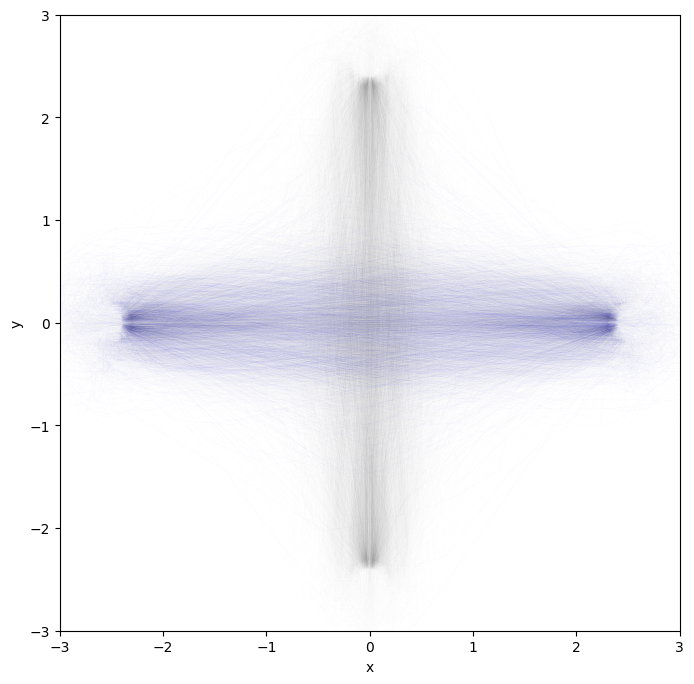

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))

ps = run.poses

for n in range(ps.shape[1]):
    color = 'k' if n else 'b'
    alpha = 0.1 if n else 0.5
    plt.plot(ps[:, n, 0], ps[:, n, 1], '-', color=color, alpha=alpha, linewidth=0.01)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-3, 3)
plt.ylim(-3, 3);

They were indeed doing a crossing pattern.

Let's plot how much the safety margin was violed.

In [8]:
import numpy as np

svs = run.safety_violations.flatten()

In [9]:
f = np.count_nonzero(svs) / len(svs)
print(f'Safety margin was violated {f:.1%} of the time')

Safety margin was violated 10.2% of the time


Most violation should be small. Let's check this by plotting their distribution.

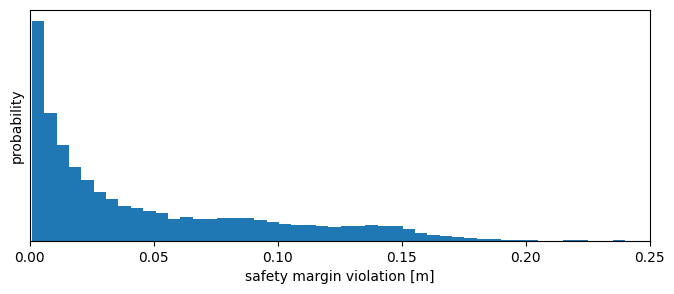

In [10]:
plt.figure(figsize=(8, 3))
plt.hist(svs, density=True, bins=np.linspace(1e-3, 0.25, 51))
plt.xlabel('safety margin violation [m]')
plt.ylabel('probability')
plt.xlim(0, 0.25)
plt.tick_params(left = False, labelleft = False);

In [11]:
np.quantile(svs, 0.999)

0.172522093915511

We look also at event logged by the agents' tasks.

For each agents, their [WaypointsTask](../reference/sim/python/tasks/waypoints.html#navground.sim.tasks.WaypointsTask.log_size) tells us when it started moving towards which waypoint as a list ``[time, target_x, target_y, target_theta]``. Let's check the first few events for the first agent.

In [12]:
task_events = [run.get_task_events(a) for a in run.world.agents]
task_events[0]
# time, x, y, theta
# np.asarray(task_events[:2]).tolist()

array([[ 0.0000e+00,  1.0000e+00,  2.5000e+00,  0.0000e+00],
       [ 4.2000e+00,  1.0000e+00, -2.5000e+00, -0.0000e+00],
       [ 9.6000e+00,  1.0000e+00,  2.5000e+00,  0.0000e+00],
       ...,
       [ 9.9861e+03,  1.0000e+00,  2.5000e+00,  0.0000e+00],
       [ 9.9912e+03,  1.0000e+00, -2.5000e+00, -0.0000e+00],
       [ 9.9965e+03,  1.0000e+00,  2.5000e+00,  0.0000e+00]])

We collect the duration to reach waypoints, ignoring the first because agents started from radom positions.  

In [13]:
dts = []

for task in task_events:
    for (start, *_), (end, *_) in zip(task[1:], task[2:]):
        duration = end - start
        dts.append(duration)

print(f'The time to reach a waypoint ranges betweeen {min(dts):.2f} and {max(dts):.2f} seconds,\n'
      'and 99% of the time between '
      f'{np.quantile(dts, 0.005):.2f} and {np.quantile(dts, 0.995):.2f} seconds') 

The time to reach a waypoint ranges betweeen 4.90 and 29.30 seconds,
and 99% of the time between 4.90 and 16.40 seconds


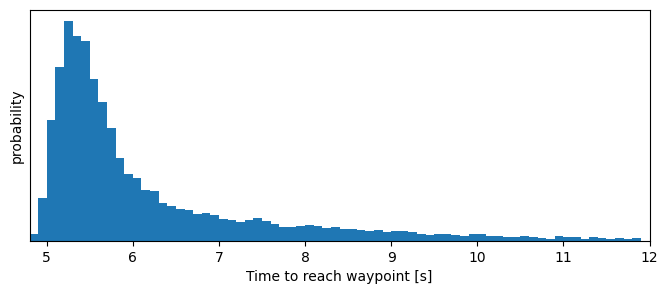

In [14]:
plt.figure(figsize=(8, 3))
plt.hist(dts, density=True, bins=np.arange(4.8, 12, 0.1))
plt.xlabel('Time to reach waypoint [s]')
plt.xlim(4.8, 12)
plt.ylabel('probability')
plt.tick_params(left = False, labelleft = False);

## Sampling per run

We want now to measure how the safety margin impacts the number of collisions. 
We define a new experiment, with many runs using randomly sampled safety radii fo the agents, so that all agents in the same run uses the same value.

In [15]:
from navground import sim

In [16]:
yaml = """
steps: 1000
time_step: 0.1
record_collisions: true
runs: 500
scenario:
  type: Cross
  radius: 5
  side: 5
  agent_margin: 0.3
  add_safety_to_agent_margin: true
  tolerance: 0.2
  position_noise: 0.2
  groups:
    - number: 10
      control_period: 0.1
      behavior:
        type: ORCA
        safety_margin:
            sampler: uniform
            from: 0.0
            to: 0.3
            once: true
      radius: 0.1
      kinematics:
        type: Omni
        max_speed: 1.0
        max_angular_speed: 3.0
      state_estimation:
        type: Bounded
        range: 2.0
"""

In [17]:
experiment = sim.load_experiment(yaml)
experiment.run()

In [18]:
print(f"Performed {len(experiment.runs)} runs in {experiment.duration.total_seconds()} seconds") 

Performed 500 runs in 4.678894 seconds


Let's collect safety margins and numbers of collisions in a table.

In [19]:
import pandas as pd

sms = []
ns = []
for run in experiment.runs.values():
    sm = np.unique([agent.behavior.safety_margin for agent in run.world.agents])
    assert len(sm) == 1
    sms += list(sm)
    ns.append(len(run.collisions))

df = pd.DataFrame({"collisions": ns, "safety_margin": sms})

and represent them with a box plot

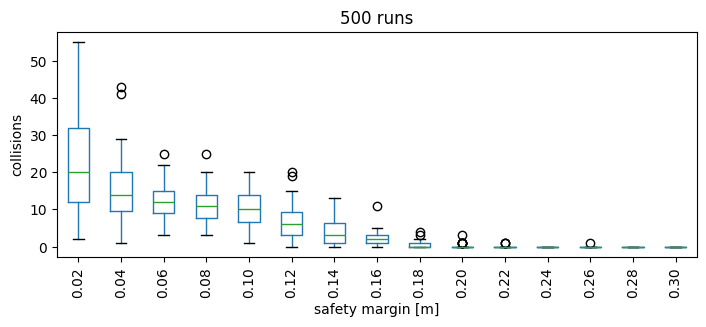

In [20]:
sms = np.linspace(0, 0.3, 16)
df['safety_margin_bin'] = pd.cut(df.safety_margin, sms)
labels = ['{:.2f}'.format(x) for x in sms[1:]]
bp = df.boxplot(column='collisions', by='safety_margin_bin', grid=False, rot=90, figsize=(8, 3))
bp.axes.set_xticklabels(labels);
bp.axes.set_xlabel("safety margin [m]")
bp.axes.set_ylabel("collisions")
bp.axes.set_title(f'{len(experiment.runs)} runs')
bp.axes.get_figure().suptitle('');

## Parallelize the execution

We can distribute the execution of an experiment over multiple threads or multiple processes. See the 
[guide on how to parallelize](../guides/parallelize.html) for more information.

Let's run again a larger experiment (5000 vs 500 runs) using 4 threads instead of 1. We will also display the progresses using tqdm.

In [21]:
from tqdm.notebook import tqdm

threads = 4
runs = 5000
experiment = sim.load_experiment(yaml)
with tqdm(total=runs) as bar:
    experiment.setup_tqdm(bar, number_of_runs=runs)
    experiment.run(number_of_threads=threads, number_of_runs=runs)

print(f"Performed {len(experiment.runs)} runs in "
      f"{experiment.duration.total_seconds()} seconds "
      f"over {threads} threads ")

  0%|          | 0/5000 [00:00<?, ?it/s]

Performed 5000 runs in 13.040602 seconds over 4 threads 


We can also parallize over *processes*.
Passing the argument `keep` will retrieve the runs performed in the dfferent processes and store them in `experiment.runs` 

In [22]:
from tqdm.notebook import tqdm

processes = 4
runs = 5000
experiment = sim.load_experiment(yaml)
with tqdm(total=runs) as bar:
    experiment.run_mp(number_of_processes=processes, number_of_runs=runs, bar=bar, keep=True)

print(f"Performed {len(experiment.runs)} runs in "
      f"{experiment.duration.total_seconds()} seconds "
      f"over {processes} processes ")

  0%|          | 0/5000 [00:00<?, ?it/s]

Performed 5000 runs in 14.04341 seconds over 4 processes 


Performing the single runs have comparable costs, but setting up the processes and retrieving the data requires additional time.

Nonetheless, multiprocessing is an important alternative that enable parallelizing experiments that invove Python, like when using Python-implemented navigation behaviors.